In [3]:
import logging
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
import sinn.histories as histories
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap
import sinn.optimize.gradient_descent as gd

import main as main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

In [4]:
import theano
import theano.tensor as T

In [3]:
#theano.config.optimizer = 'None'
#theano.config.exception_verbosity = 'high'
#theano.config.mode = 'FAST_COMPILE'

# Data generation

Generate spike trains. If the specified filename already exists, the precomputed data is used instead.

*Note*: Spike trains use relatively fine time bins (0.2&nbsp;ms). This is because spike times must be precise relative to the timescale of the PSP kernel (i.e. $τ_m$).

In [4]:
source_datalen = 20 # Use 4 seconds of data
datalen = 20        # Amount of data to use for likelihood
#datalen = 2.5
burnin = 0           # Amount of data to discard from likelihood
mbatch_size = 100    # Batch size when computing likelihood / gradients

In [5]:
main.load_parameters("main.params")
main.load_theano()

In [6]:
spikemodel = main.generate_spikes(burnin+datalen,
                                  filename='data/short_adap/spikes/fsgif_sin-input_{}s_314seed'
                                           .format(source_datalen))

2017-08-10 22:30:39,027 - root - INFO - Checking for precomputed data...
2017-08-10 22:30:40,428 - root - INFO - Precomputed data found. Skipping data generation


Compute the activity trace by summing over spikes. We subsample the result because the activity trace uses a coarser time bin of 1&nbsp;ms.

*Note*: When subsampling, we average over $n$ bins and combine into one, so we aren't just throwing away 80% of our data.

In [7]:
main.compute_spike_activity(max_len=burnin+datalen)

(<sinn.histories.Series at 0x7f76aae719e8>,
 <sinn.histories.Series at 0x7f76aae71898>)

Plot the generated data.

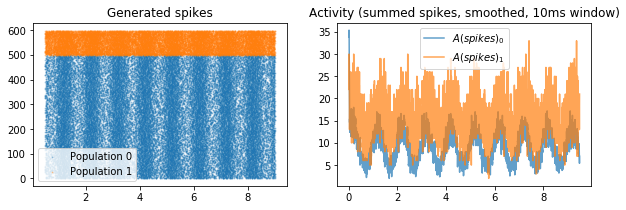

In [8]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen-burnin)

plt.subplot(1,2,2)
main.plot_spike_activity()

In [8]:
for s in ['spiking model', 'spike activity']:
    if s in main.loaded:
        del main.loaded[s]
spikemodelMLE = main.generate_spikes(datalen,
                                     filename='data/short_adap/fsgif_{}s_sin-input_MLE'
                                              .format(6))
main.compute_spike_activity()

2017-08-10 14:20:58,724 - root - INFO - Checking for precomputed data...
2017-08-10 14:20:59,644 - root - INFO - Precomputed data found. Skipping data generation


(<sinn.histories.Series at 0x7f3b8d9b6a90>,
 <sinn.histories.Series at 0x7f3b8d9b6e10>)

IndexError: index 54407 is out of bounds for axis 0 with size 36909

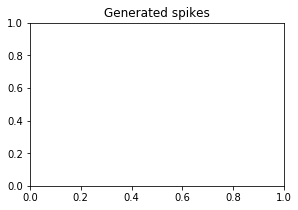

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen)

plt.subplot(1,2,2)
main.plot_spike_activity()
plt.ylim((0, 37))

In [11]:
burnin_idx = int( (.5/main.mf_dt)  // mbatch_size * mbatch_size )
stop_idx = int( burnin+datalen // main.mf_dt )

# Observed vs predicted population
Todo

In [9]:
main.generate_activity(datalen=burnin+datalen)

2017-08-10 21:58:40,249 - root - INFO - Checking for precomputed data...
2017-08-10 21:58:40,251 - root - INFO - No precomputed data found. Generating new data...
2017-08-10 22:00:47,411 - sinn.iotools - WARNING - Unable to save to raw format. Will try a plain (dill) pickle dump.
2017-08-10 22:00:48,413 - root - INFO - Done.
2017-08-10 22:00:48,414 - sinn - WARNING - Some probabilities were clipped.


In [ ]:
mfmodel = main.derive_mf_model_from_spikes()
mfmodel.nbar.compute_up_to(stop_idx)

In [12]:
main.loaded['spike activity']

{'Ahist': <sinn.histories.Series at 0x7f5480748438>,
 'Ihist': <sinn.histories.Series at 0x7f5480748668>}

# NumPy vs Theano state variables

(unfinished)

In [9]:
mfmodel = main.derive_mf_model_from_spikes()

2017-08-10 22:30:50,422 - root - INFO - Producing Theano mean-field model.
2017-08-10 22:30:53,612 - root - INFO - Theano model complete.


In [12]:
mfmodel.advance(stop_idx)

2017-08-10 22:31:03,219 - fsgif_model - INFO - Compiling advance function.
2017-08-10 22:31:03,228 - theano_shim - INFO - Clearing Theano updates
2017-08-10 22:31:08,755 - theano_shim - INFO - Clearing Theano updates
2017-08-10 22:31:08,758 - fsgif_model - INFO - Done.


In [21]:
mfmodel.u._data.get_value()[2000]

array([[  0.   ,   0.   ],
       [  1.265,   0.964],
       [  2.184,   1.878],
       ..., 
       [ 22.234,  20.575],
       [ 22.234,  20.575],
       [ 22.234,  20.575]])

## Plot likelihood slice

In [8]:
mfmodel = main.init_mean_field_model(main.loaded['spike activity']['Ahist'],
                                     main.loaded['spike activity']['Ihist'],
                                     datalen=datalen)

AssertionError: 

In [ ]:
%debug

> /home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/scalar/basic.py(284)convert()
    282             if x_.size == 0 and not hasattr(x, 'dtype'):
    283                 x_ = numpy.asarray(x, dtype=config.floatX)
--> 284     assert type(x_) in [numpy.ndarray, numpy.memmap]
    285     return x_
    286 

ipdb> x_
ShimmedShared([[  0.,   0.],
               [  0.,   0.],
               [  0.,   0.],
               ..., 
               [ 10.,  30.],
               [  6.,  20.],
               [  6.,  10.]])
ipdb> up
> /home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py(234)constant_or_value()
    232 
    233     """
--> 234     x_ = scal.convert(x, dtype=dtype)
    235 
    236     bcastable = [d == 1 for d in x_.shape]

ipdb> up
> /home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py(264)constant()
    262 def constant(x, name=None, ndim=None, dtype=None):
    263     ret = constant_or_value(x, rtype=TensorConstant, n

In [17]:
mfmodel.loglikelihood(0.5, 4000)

(ShimmedShared(-11914925.216909036), OrderedDict())

In [20]:
mfmodel.params.w[0,0] = -1
print(mfmodel.params.w)

In [22]:
mfmodel.clear_unlocked_histories()

In [23]:
mfmodel.loglikelihood(0.5, 4000)

(ShimmedShared(-12015836.34452564), OrderedDict())

In [27]:
def logL(w00):
    mfmodel.params.w[0,0] = w00
    mfmodel.clear_unlocked_histories()
    return mfmodel.loglikelihood(0.5, 4000)[0]

In [25]:
w00_arr = np.linspace(-1, 2.5, 10)

In [28]:
logL_arr = np.array([logL(w00) for w00 in w00_arr])

In [1]:
np.log10(934343)

NameError: name 'np' is not defined

In [81]:
def nlog10(x, n):
    for i in range(n):
        x = x - min(x) + np.mean(abs(x)) / 100
        x = x / min(abs(x))
        x = np.log10(x)
    return x

(-0.5, 2.5)

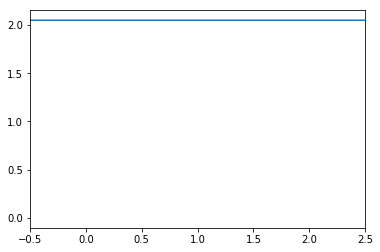

In [87]:
plt.plot(w00_arr, nlog10(logL_arr, 10))
plt.xlim((-0.5, 2.5))

In [66]:
np.set_printoptions(precision=8, suppress=True)

In [86]:
nlog10(logL_arr, 10)

array([ 0.        ,  2.04964081,  2.04964749,  2.04964994,  2.04964995,
        2.04964995,  2.04964994,  2.04964994,  2.04964994,  2.04964994])

In [80]:
a - min(a) + min(abs(a)) / 100

array([ 0.        ,  0.00893215,  0.06933814,  0.26631009,  0.26658961,
        0.26651607,  0.26645189,  0.2663932 ,  0.26633868,  0.26629136])

## (Debug) Testing generated activity

In [10]:
mfmodel = main.generate_activity(datalen, autosave=False)

2017-08-10 22:02:44,228 - root - INFO - Precomputed data found. Skipping data generation


UnboundLocalError: local variable 'mf_model' referenced before assignment

(-10, 100)

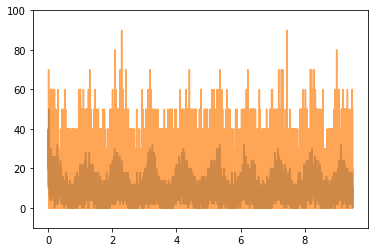

In [12]:
anlz.plot(mfmodel.A, alpha=0.7)
#anlz.plot(main.loaded['mf model'].A, alpha=0.7)
plt.ylim((-10, 100))

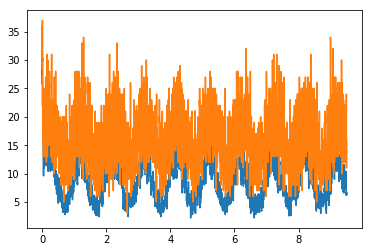

In [14]:
anlz.plot(anlz.smooth(mfmodel.A, 10))

In [20]:
max(int(np.rint(0.01 / main.mf_dt)), 1)

10

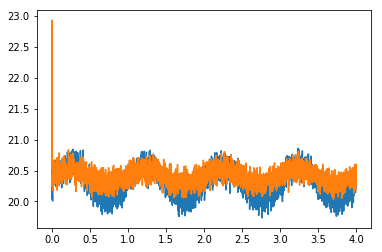

In [8]:
anlz.plot(mfmodel.h_tot)

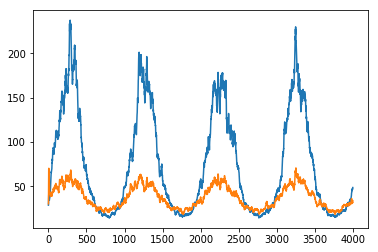

In [20]:
anlz.plot(mfmodel.λ.get_trace(700))

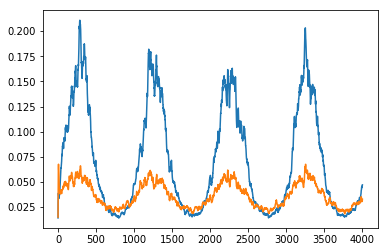

In [18]:
anlz.plot(mfmodel.P_λ.get_trace(700))

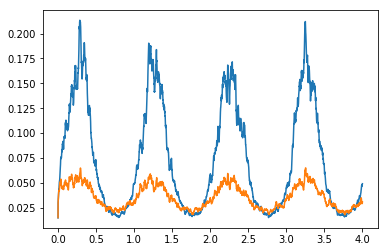

In [7]:
anlz.plot(mfmodel.Pfree)

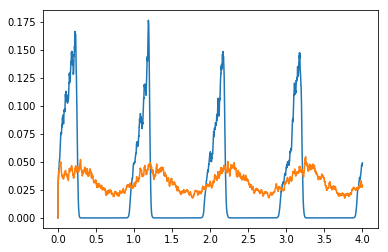

In [10]:
anlz.plot(mfmodel.P_Λ)

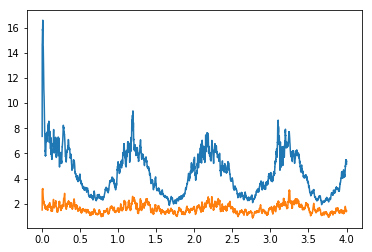

In [11]:
anlz.plot(mfmodel.nbar)

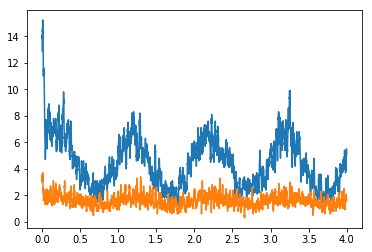

In [14]:
anlz.plot(anlz.smooth(mfmodel.n, 10))

## (End debug)

In [10]:
#mfmodel = main.derive_mf_model_from_spikes()

#mfmodel.nbar.compute_up_to('end')
#def logL_fn():
#    return mfmodel.loglikelihood(burnin_idx, stop_idx-burnin_idx)[0]

array([ 7.23 ,  1.451])

In [11]:
#del main.loaded['derived mf model']

In [12]:
sinn.inputs.clear()

main.load_theano()

In [13]:
main.loaded['spike activity']['Ahist'].unlock()
main.loaded['spike activity']['Ihist'].unlock()
main.loaded['spike activity']['Ahist'].theano_reset()
main.loaded['spike activity']['Ihist'].theano_reset()
main.loaded['spike activity']['Ahist'].lock()
main.loaded['spike activity']['Ihist'].lock()
try:
    mfmodelT.theano_reset()
    mfmodelT.clear_unlocked_histories()
except NameError:
    pass
mfmodelT = main.derive_mf_model_from_spikes()

2017-07-18 18:16:42,571 - root - INFO - Producing Theano mean-field model.
2017-07-18 18:16:51,511 - root - INFO - Theano model complete.


In [14]:
mfmodelT.theano_reset()
mfmodelT.clear_unlocked_histories()

2017-07-18 18:16:51,517 - theano_shim - INFO - Clearing Theano updates


# Debugging

In [14]:
tidx = shim.getT().lscalar('tidx')

ShimmedShared(-11940.789625753345)

In [18]:
x = mfmodelT.nbar[tidx]
f = theano.function([tidx], x, updates=shim.get_updates())

/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-07 00:21:06,920 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-07 00:21:06,921 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-07 00:21:06,933 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-07 00:21:06,934 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-07 00:21:06,937 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-07 00:21:06,938 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwise{switch,no_inplace}.0
2017-07-07 00:21:06,975 - theano_shim - INFO - Adding 

OrderedDict([(y data, if{}.0), (t idx (y), Elemwise{switch,no_inplace}.0), (h_tot data, if{}.0), (t idx (h_tot), Elemwise{switch,no_inplace}.0), (u data, if{}.0), (t idx (u), Elemwise{switch,no_inplace}.0), (g data, if{}.0), (t idx (g), Elemwise{switch,no_inplace}.0), (varθfree data, if{}.0), (t idx (varθfree), Elemwise{switch,no_inplace}.0), (varθ data, if{}.0), (t idx (varθ), Elemwise{switch,no_inplace}.0), (λ data, if{}.0), (t idx (λ), Elemwise{switch,no_inplace}.0), (P_λ data, if{}.0), (t idx (P_λ), Elemwise{switch,no_inplace}.0), (m data, if{}.0), (t idx (m), Elemwise{switch,no_inplace}.0), (W data, if{}.0), (t idx (W), Elemwise{switch,no_inplace}.0), (h data, if{}.0), (t idx (h), Elemwise{switch,no_inplace}.0), (λfree data, if{}.0), (t idx (λfree), Elemwise{switch,no_inplace}.0), (Pfree data, if{}.0), (t idx (Pfree), Elemwise{switch,no_inplace}.0), (x data, if{}.0), (t idx (x), Elemwise{switch,no_inplace}.0), (v data, if{}.0), (t idx (v), Elemwise{switch,no_inplace}.0), (Z data, 

In [16]:
f(0)

array([ 7.23 ,  1.451])

# Not Debugging

In [15]:
tidx = shim.getT().lscalar('tidx')
logL_graph, statevar_upds, shared_upds = mfmodelT.loglikelihood(tidx, mbatch_size)
logger.info("Compiling Theano loglikelihood")
#logL_step = shim.gettheano().function([tidx], logL_graph,
#                                      updates=upds)
logL_step = shim.gettheano().function([tidx], logL_graph)
logger.info("Done compilation.")
mfmodelT.theano_reset()

def logL_fnT(model):
    mfmodelT.clear_unlocked_histories()
    #mfmodelT.advance(burnin_idx)
    logL = 0
    for i in range(burnin_idx, stop_idx, mbatch_size):
        mfmodelT.advance(i)
        logL += logL_step(i)
    #return sum(logL_step(i)
    #           for i in range(burnin_idx, stop_idx, mbatch_size))

2017-07-10 14:23:54,919 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-10 14:23:54,974 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-10 14:23:54,975 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-10 14:23:54,989 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-10 14:23:54,990 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-10 14:23:54,993 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-10 14:23:54,994 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwis

In [10]:
tidx = shim.getT().lscalar('tidx')
logL_graph, upds = mfmodelT.loglikelihood(tidx, mbatch_size)

2017-07-07 14:35:50,680 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-07 14:35:50,743 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-07 14:35:50,745 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-07 14:35:50,760 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-07 14:35:50,762 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-07 14:35:50,765 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-07 14:35:50,766 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwis

In [14]:
ggraph = T.grad(logL_graph, mfmodelT.params.w)

In [15]:
g = theano.function([tidx], ggraph)

In [17]:
g(2)

array([[ 0.,  0.],
       [ 0.,  0.]])

In [ ]:
logL_step(burnin_idx)

In [23]:
mfmodel.loglikelihood(burnin_idx, mbatch_size)[0]

ShimmedShared(-8953.556386109334)

In [25]:
mfmodel.loglikelihood(burnin_idx, 1)[0] + mfmodel.loglikelihood(burnin_idx+1, 1)[0]

ShimmedShared(-11940.789625753345)

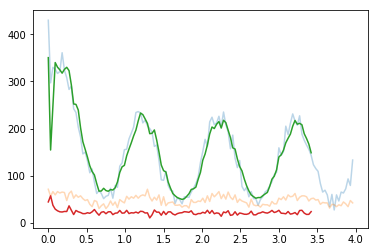

In [18]:
anlz.plot(mfmodelT.n, alpha=0.3)
anlz.plot(mfmodelT.nbar)

# Plot grad

In [15]:
mfmodelT.advance(2999)

In [16]:
mfmodelT.nbar._original_tidx.get_value()

array(2998)

In [17]:
tidx = T.iscalar('t idx')
L_graph = mfmodelT.loglikelihood(tidx, 1)[0]

2017-07-11 14:46:14,451 - fsgif_model - INFO - Producing the likelihood graph.
/home/alex/usr/venv/mackelab/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-07-11 14:46:14,513 - theano_shim - INFO - Adding Theano update : y data -> if{}.0
2017-07-11 14:46:14,515 - theano_shim - INFO - Adding Theano update : t idx (y) -> Elemwise{switch,no_inplace}.0
2017-07-11 14:46:14,531 - theano_shim - INFO - Adding Theano update : h_tot data -> if{}.0
2017-07-11 14:46:14,533 - theano_shim - INFO - Adding Theano update : t idx (h_tot) -> Elemwise{switch,no_inplace}.0
2017-07-11 14:46:14,537 - theano_shim - INFO - Adding Theano update : u data -> if{}.0
2017-07-11 14:46:14,539 - theano_shim - INFO - Adding Theano update : t idx (u) -> Elemwis

In [18]:
g_graph = T.grad(L_graph, mfmodelT.params.τ_m)

In [19]:
[i for i in theano.gof.graph.inputs([g_graph]) if shim.is_theano_variable(i)]

[t idx]

In [20]:
g_fn = theano.function([tidx], g_graph)

In [23]:
g_fn(50)

array([ 0.,  0.])

if{}.0

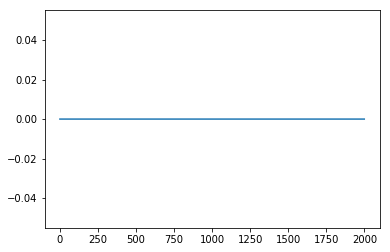

In [22]:
plt.plot([g_fn(i)[1] for i in range(2000)])

# Gradient descent

In [14]:
# Clamp parameters: only parameters whose mask is set to True are fit
fitmask = {mfmodelT.params.c: False,
           mfmodelT.params.w: np.array([[True, False],
                                        [False, False]]),
           mfmodelT.params.τ_m: np.array([False, True])}

In [15]:
# DEBUG
#gd.debug_flags['print grads'] = 'logτ_m'

In [16]:
sgd = gd.SGD(mfmodelT.loglikelihood,
             optimizer = 'adam',
             model = mfmodelT,
             burnin = burnin,
             datalen = datalen,
             mbatch_size = mbatch_size)

array([ 0.,  0.])

In [17]:
sgd.transform( mfmodelT.params.τ_m, 'logτ_m',
               'τ -> shim.log10(τ)', 'logτ -> 10**logτ' )

2017-07-18 18:11:16,021 - theano_shim - INFO - Clearing Theano updates
2017-07-18 18:11:16,025 - fsgif_model - INFO - Producing the likelihood graph.
2017-07-18 18:11:16,246 - fsgif_model - INFO - Likelihood graph complete
2017-07-18 18:11:16,251 - theano_shim - INFO - Clearing Theano updates


In [18]:
sgd.compile( fitparams = fitmask, 
             lr = 0.005
           )

2017-07-18 18:11:16,257 - theano_shim - INFO - Clearing Theano updates
2017-07-18 18:11:16,261 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-07-18 18:11:16,262 - fsgif_model - INFO - Producing the likelihood graph.
2017-07-18 18:11:16,481 - fsgif_model - INFO - Likelihood graph complete
2017-07-18 18:11:16,482 - sinn.optimize.gradient_descent - INFO - Cost function graph complete.
2017-07-18 18:11:16,483 - sinn.optimize.gradient_descent - INFO - Performing variable substitutions in Theano graph.
2017-07-18 18:11:16,494 - sinn.optimize.gradient_descent - INFO - Substitutions complete.
2017-07-18 18:11:16,495 - sinn.optimize.gradient_descent - INFO - Compiling the minibatch cost function.
2017-07-18 18:11:18,574 - sinn.optimize.gradient_descent - INFO - Done compilation.
2017-07-18 18:11:18,575 - sinn.optimize.gradient_descent - INFO - Calculating Adam optimizer updates.
2017-07-18 18:11:27,371 - sinn.optimize.gradient_descent - INFO - Done calcu

In [19]:
sgd.set_ground_truth(mfmodelT.params)

evols = []

In [20]:
sgd.iterate(Nmax=5e0, cost_calc='full', cost_period=5)

2017-07-18 18:12:17,521 - sinn.optimize.gradient_descent - INFO - Iteration 5 – <log L> = -2482.14
2017-07-18 18:12:17,523 - sinn.optimize.gradient_descent - INFO -              Last evaluated log L: -23873666.780279502
2017-07-18 18:12:17,524 - sinn.optimize.gradient_descent - INFO - Cost/likelihood evaluation : 0.5s / 3.1s (17.0% total execution time)
2017-07-18 18:12:17,525 - sinn.optimize.gradient_descent - INFO - Time per iteration: 629.257ms


Did not converge.


In [21]:
io.saveraw("data/short_adap/fit_test", sgd)

In [15]:
othersgd = gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam', sgd_file="data/short_adap/fit_test")

In [20]:
othersgd.trueparams.keys()

dict_keys([R, c, w, J_θ, Δu, u_rest, Γ, u_r, u_th, τ_s, t_ref, N, p, τ_m, τ_θ, Δ, logτ_m])

In [ ]:
othersgd.verify_transforms()

In [ ]:
othersgd.trueparams

In [34]:
sgd.param_evol

{w: deque([array([[ 0.176, -0.702],
               [ 0.176, -0.702]]), array([[ 0.181, -0.702],
               [ 0.176, -0.702]]), array([[ 0.185, -0.702],
               [ 0.176, -0.702]]), array([[ 0.185, -0.702],
               [ 0.176, -0.702]]), array([[ 0.184, -0.702],
               [ 0.176, -0.702]]), array([[ 0.187, -0.702],
               [ 0.176, -0.702]])]),
 c: deque([array([ 10.,  10.]),
        array([ 10.,  10.]),
        array([ 10.,  10.]),
        array([ 10.,  10.]),
        array([ 10.,  10.]),
        array([ 10.,  10.])]),
 logτ_m: deque([array([-1.699, -1.699]),
        array([-1.699, -1.694]),
        array([-1.699, -1.689]),
        array([-1.699, -1.685]),
        array([-1.699, -1.685]),
        array([-1.699, -1.687])])}

In [20]:
print(mfmodelT.params.w.get_value())
print(np.exp(mfmodelT.params.logτ_m.get_value()))

array([[ 0.176, -0.702],
       [ 0.176, -0.702]])

In [22]:
print(mfmodelT.params.w.get_value())
print(mfmodelT.params.τ_m.get_value())

[[ 0.322 -0.702]
 [ 0.176 -0.702]]
[ 0.02  0.02]


In [22]:
10**(sgd.get_evol()['logτ_m'])[0]

array([ 0.02,  0.02])

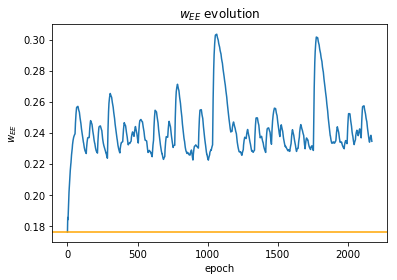

In [20]:
plt.title('$w_{EE}$ evolution')
plt.plot(sgd.get_evol()['w'][:,0,0])
plt.xlabel("epoch")
plt.ylabel("$w_{EE}$")
plt.axhline(0.176, color='orange')

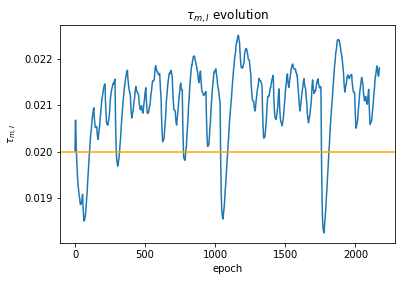

In [21]:
plt.title('$τ_{m,I}$ evolution')
plt.plot(10**(sgd.get_evol()['logτ_m'][:,1]))
plt.xlabel('epoch')
plt.ylabel('$τ_{m,I}$')
plt.axhline(0.02, color='orange')

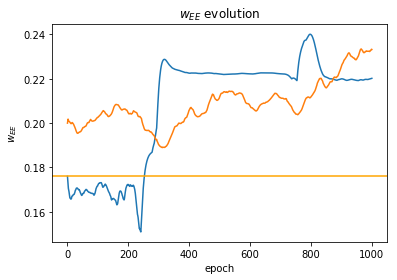

In [22]:
plt.title('$w_{EE}$ evolution')
plt.plot(sgd.get_evol()['w'][:,0,0])
plt.plot(10**(sgd.get_evol()['logτ_m'][:,1]) * 10)
plt.ylabel("$w_{EE}$")
plt.xlabel("epoch")
plt.axhline(0.176, color='orange')

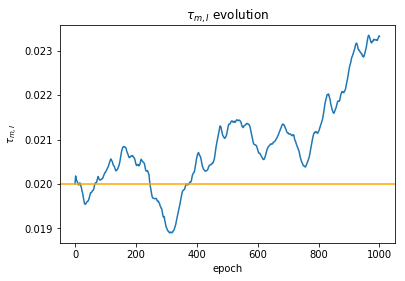

In [23]:
plt.title('$τ_{m,I}$ evolution')
plt.plot(10**(sgd.get_evol()['logτ_m'][:,1]))
plt.xlabel('epoch')
plt.ylabel('$τ_{m,I}$')
plt.axhline(0.02, color='orange')

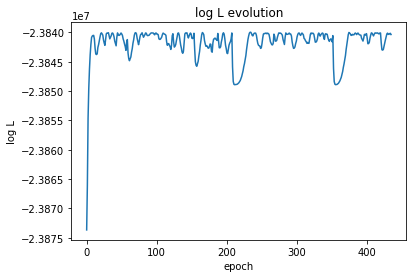

In [22]:
plt.title("log L evolution")
plt.plot(sgd.get_evol()['logL'])
plt.xlabel("epoch")
plt.ylabel("log L")

'/home/alex/Recherche/macke_lab/code/fsGIF/data/sgd_mb100_logL_data.sin'

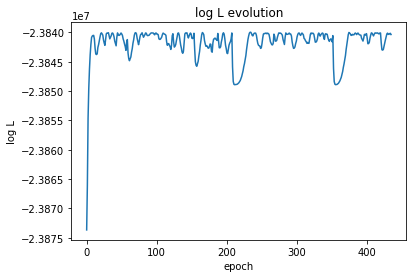

In [23]:
io.save("data/sgd_mb100_logL_data.sin", (sgd.tot_time, sgd.cum_step_time, sgd.get_evol()))

In [50]:
tot_time, cum_step_time, evol = io.load("data/sgd_data.sin")

In [ ]:
plt.plot(evol[''][:,0,0])

In [25]:
plt.plot(evol[''][:,0,0])

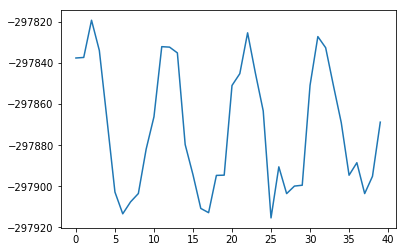

In [25]:
plt.plot(sgd.step_cost)

In [24]:
import os.path
basedir = os.path.expanduser('~/Recherche/macke_lab/code/fsGIF/data/short_adap/')
basedir = os.path.expanduser('~/Recherche/macke_lab/labnotes/plots/2017-07-05/')
filename_base = basedir + "fsgif_{}s_sin-input_likelihood_2"
filename = filename_base.format(8)

In [25]:
logL = HeatMap.from_raw(io.loadraw(filename))

In [26]:
logL.set_floor(logL.max() - 40)

In [29]:
logL.set_floor(logL.max() - 40)

(0.0027613525995958672, 0.1)

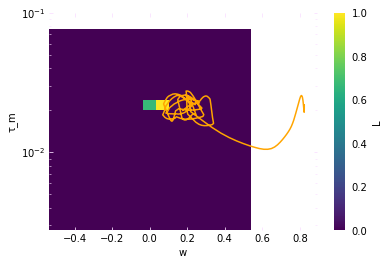

In [29]:
L = main.exploglikelihood(logL)
anlz.plot(L)
sgd.plot_param_evol_overlay(L, color='orange')
plt.ylim(ymax=0.1)

(0.0027613525995958672, 0.1)

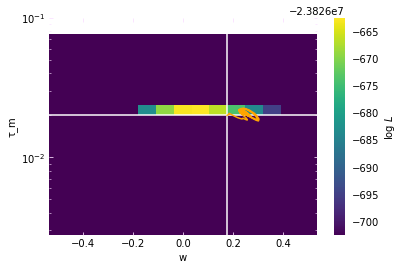

In [27]:
anlz.plot(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)
sgd.plot_param_evol_overlay(logL, color='orange')
plt.ylim(ymax=0.1)

## New machine
First number: gradient evaluation <br>
Second number: likelihood evaluation

In [15]:
n = 10
i0 = 0

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd._step(i)
t2 = time.perf_counter()
print((t2-t1)/n)

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd.cost(i)
t2 = time.perf_counter()

print((t2-t1)/n)

4.71606696099916
0.2595898110012058


## Old Power Mac
First number: gradient evaluation<br>
Second number: likelihood evaluation

In [14]:
n = 10
i0 = 0

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd._step(i)
t2 = time.perf_counter()
print((t2-t1)/n)

t1 = time.perf_counter()
for i in range(i0, i0+n):
    sgd.cost(i)
t2 = time.perf_counter()

print((t2-t1)/n)

29.315469363494778
0.36129934259224683


In [12]:
sgd.iterate(Nmax=1e3)

KeyboardInterrupt: 

In [13]:
sgd.step_i

0

In [11]:
logL_fn = theano.function([], logL_graph)

In [15]:
logL_fn = theano.function([], logL_graph)

In [15]:
theano.printing.pydotprint(logL_fn, outfile="logL_pydot.png", scan_graphs=True)

The output file is available at logL_pydot_scan_fn_162.png
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.827805 to fit

The output file is available at logL_pydot.png


In [13]:
logL_fn()

[array(-29679.126253179962)]

In [6]:
mfmodel = main.derive_mf_model_from_spikes()
gradlogL = main.compile_theano_gradloglikelihood2(mfmodel.params.w)

2017-06-27 21:55:47,167 - root - INFO - Producing Theano mean-field model.
2017-06-27 21:56:20,749 - theano_shim - INFO - Adding Theano update : θ_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-27 21:56:20,750 - theano_shim - INFO - Adding Theano update : t idx (θ_dis) -> Elemwise{switch,no_inplace}.0
/home/alex/usr/venv/mackelab/lib64/python3.4/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
2017-06-27 21:56:20,757 - theano_shim - INFO - Adding Theano update : θtilde_dis data -> IncSubtensor{Set;int64:int64:}.0
2017-06-27 21:56:20,758 - theano_shim - INFO - Adding Theano update : t idx (θtilde_dis) -> Elemwise{switch,no_inplace}.0
2017-06-27 21:56:21,287 - root - INFO - Theano model complete.
2017-06-27 21:56:21,288 - root - INFO - Produc

In [7]:
gradlogL(0.5, 3.4)

2017-06-27 21:57:12,656 - root - INFO - Computing loglikelihood gradient.
2017-06-27 21:57:48,860 - root - INFO - Done.


array([[-27.418,  -5.134],
       [ 18.957,   8.997]])

Create the activity model we will fit, with activity trace and input constrained by the spike data.

# Visual validation

To check that the models are consistent, we instantiate a second mean-field model with the same input but let it compute the activity trace. We check that the trace it produces is consistent with the one we will fit to.

In [6]:
mfmodel_unconstrained = main.init_mean_field_model(activity_history = None,
                                                   input_history = Ihist,
                                                   model_params = mfmodel.params)

mfmodel_unconstrained.A.name = 'A (mf)'

In [7]:
mfmodel_unconstrained.A.set()  # Compute A

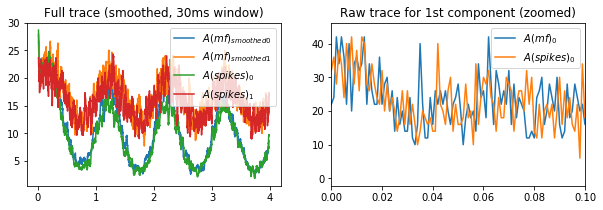

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Full trace (smoothed, 30ms window)")
anlz.plot(anlz.smooth(mfmodel_unconstrained.A, 30))
anlz.plot(anlz.smooth(Ahist, 30), label='A (spikes)')
plt.legend()

plt.subplot(1,2,2)
plt.title("Raw trace for 1st component (zoomed)")
anlz.plot(mfmodel_unconstrained.A, component=0)
anlz.plot(Ahist, label='A (spikes)', component=0)
plt.legend()
plt.xlim((0.0, 0.1))

None

# Likelihood sweep

Below we plot the unnormalized likelihood. True parameters have non-zero probability (~5x less then the MLE).

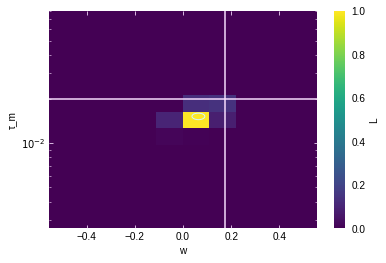

In [10]:
main.plot_likelihood('fsgif_loglikelihood_{}s_sin-input.dat'.format(datalen),
                     ellipse=None,
                     true_params=(true_params.w[0][0],
                                  true_params.τ_m[0]),
                     recalculate=True)

# Scan-less gradient

Since defining a likelihood using `scan` is a problem, we have to backpropagate the gradients one step ourselves. All we need to specify is the list of state variables through which the gradient needs to be propagated.
$\newcommand{\statevar}{\mathcal{x}}$

We define $\statevar_i$ to be the collection of all state variables at time $t_i$ required to compute $L(n_i | \theta)$. Lacking a dedicated symbol for the partial gradient, we define a surrogate variable $\hat{\theta} := \theta$, in line with the notation of the *Deep Learning* book.

\begin{align*}
\nabla_\theta \log L(n_: | \theta) &= \sum_i \nabla_\theta \log L(n_i | \statevar_i(\theta, \statevar_{i-1}(\theta), n_{:i-1})) \\
&= \sum_i \nabla_{\statevar_i} \log L(n_i | \statevar_i) \, \nabla_{\theta} \statevar_i(\theta, \statevar_{i-1}(\theta), n_{:i-1}) \\
&= \sum_i \nabla_{\statevar_i} \log L(n_i | \statevar_i) \, \left[ \nabla_{\hat{\theta}} \statevar_i(\hat{\theta}, \statevar_{i-1}(\theta), n_{:i-1}) + \nabla_{\statevar_{i-1}} \statevar_i(\theta, \statevar_{i-1}, n_{:i-1}) \, \nabla_{\theta} \statevar_{i-1} \right]
\end{align*}

In the common case where $\statevar$ is not scalar, quantities such as $\nabla_{\theta} \statevar_{i}$ are to be interpreted as the Jacobian matrix
$$\begin{pmatrix}
\frac{\partial x_{i,1}}{\partial \theta_{i,1}} & \frac{\partial x_{i,1}}{\partial \theta_{i,2}} & \dots \\
\frac{\partial x_{i,2}}{\partial \theta_{i,1}} & \ddots \\
\vdots
\end{pmatrix}$$

Thus we begin by initializing<br>
$J_{state} = \nabla_{\theta} \statevar_{0} \leftarrow 0 \,.$<br>
We then iterate over $i$, at every step computing three gradients
  - $g_1 \leftarrow \nabla_{\statevar_i} \log L(n_i | \statevar_i)$
  - $J_2 \leftarrow \nabla_{\hat{\theta}} \statevar_i(\hat{\theta}, \statevar_{i-1}(\theta), n_{:i-1})$
  - $J_3 \leftarrow \nabla_{\statevar_{i-1}} \statevar_i(\theta, \statevar_{i-1}, n_{:i-1})$
  
and setting
  - $J_{state} \leftarrow J_2 + J_3 \cdot J_{state}$
  - $\nabla_\theta \log L(n_i | \statevar_i(\theta, \statevar_{i-1}(\theta), n_{:i-1})) \leftarrow g_1^\intercal \cdot J_{state}$

# Model equations

## Spiking model

\begin{gather}
u_{l, i} = \begin{cases}
u_{l-1, i} e^{-Δt/τ_m} + \bigl[u_{rest}^{α(i)} + R I_{ext}^{α(i)}(l) + R I_{syn, i}(l) \bigr]  (1 - e^{-Δt/τ_m}) & \text{if $\hat{t}_i \geq t_{ref}^{α(i)}$} \\
u_{rest}^{α(i)} & \text{otherwise}
\end{cases}
\end{gather}